In [1]:
import json
import pandas as pd
from pymongo import MongoClient
from helpers import plotOwners, plotNewOwners, remove0s, count0s

In [2]:
client = MongoClient('localhost', 27017)
db = client.steamspy

In [3]:
data = pd.DataFrame(list(db.clean.find()))

In [4]:
data.drop(columns = "_id", inplace = True) #drop _id column

In [5]:
#gamefeatures= pd.read_csv("gamefeatures.csv")

In [6]:
#gamefeatures = gamefeatures.rename(columns = {'QueryID':'id'})

In [7]:
# gamefeatures = gamefeatures.drop(columns = ['ResponseID', 'QueryName', 'ResponseName', 'DemoCount', 'DeveloperCount', 'DLCCount',
#                             'MovieCount', 'PackageCount', 'PublisherCount', 'ScreenshotCount',
#                             'SteamSpyOwners', 'SteamSpyOwnersVariance', 'SteamSpyPlayersEstimate',
#                             'SteamSpyPlayersVariance', 'AchievementHighlightedCount', 'IsFree', 'FreeVerAvail',
#                             'PurchaseAvail', 'PCReqsHaveMin', 'PCReqsHaveRec', 'LinuxReqsHaveMin', 
#                             'LinuxReqsHaveRec', 'MacReqsHaveMin', 'MacReqsHaveRec', 'CategorySinglePlayer',
#                             'CategoryMultiplayer', 'CategoryCoop', 'CategoryMMO', 'CategoryInAppPurchase',
#                             'CategoryIncludeSrcSDK', 'CategoryIncludeLevelEditor', 'CategoryVRSupport', 
#                             'GenreIsNonGame', 'GenreIsIndie', 'GenreIsAction', 'GenreIsAdventure', 'GenreIsCasual',
#                             'GenreIsStrategy', 'GenreIsRPG', 'GenreIsSimulation', 'GenreIsEarlyAccess', 
#                             'GenreIsFreeToPlay', 'GenreIsSports', 'GenreIsRacing', 'GenreIsMassivelyMultiplayer', 
#                             'PriceCurrency', 'PriceInitial', 'PriceFinal', 'SupportEmail', 'SupportURL', 
#                             'AboutText', 'Background', 'ShortDescrip', 'DetailedDescrip', 'DRMNotice', 
#                             'ExtUserAcctNotice', 'HeaderImage', 'LegalNotice', 'Reviews', 'SupportedLanguages',
#                             'Website', 'PCMinReqsText', 'PCRecReqsText', 'LinuxMinReqsText', 'LinuxRecReqsText',
#                             'MacMinReqsText', 'MacRecReqsText']) #dropping useless columns

In [8]:
#gamefeatures = gamefeatures.rename(columns = {'id':'appid'}) #match datas id column

In [9]:
#df = pd.merge(gamefeatures, data, on=['appid'], how='left')

In [10]:
#merged = db.merged

In [11]:
#records = json.loads(df.T.to_json()).values() #store the merged df in mongo
#merged.insert(records)

In [12]:
free = data[data['Genres'].apply(lambda x: 'Free' in x)] 
paid = data[data['Genres'].apply(lambda x: 'Free' not in x)] 

In [13]:
freeOwnersL = free['llOwners'].sum()
paidOwnersL = paid['llOwners'].sum()
freeOwnersU = free['ulOwners'].sum()
paidOwnersU = paid['ulOwners'].sum()

In [14]:
dfFree = pd.DataFrame({'Type':['Free', 'Paid'], 'Lower Limit Owners':[freeOwnersL, paidOwnersL], 'Upper Limit Owners':
                      [freeOwnersU, paidOwnersU]})

In [15]:
import matplotlib.pyplot as plt

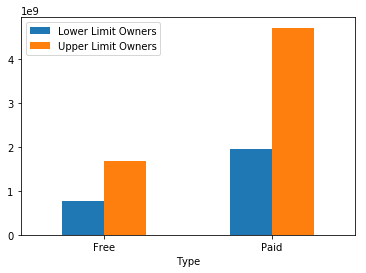

In [16]:
ax = dfFree.plot.bar(x = 'Type',rot=0) # number of free and paid games owned by people

In [17]:
action = data[data['Genres'].apply(lambda x: 'Action' in x)]
earlyAccess = data[data['Genres'].apply(lambda x: 'Early Access' in x)]
strategy = data[data['Genres'].apply(lambda x: 'Strategy' in x)]
rpg = data[data['Genres'].apply(lambda x: 'RPG' in x)]
indie = data[data['Genres'].apply(lambda x: 'Indie' in x)]
adventure = data[data['Genres'].apply(lambda x: 'Adventure' in x)]
sports = data[data['Genres'].apply(lambda x: 'Sports' in x)]
simulation = data[data['Genres'].apply(lambda x: 'Simulation' in x)]
exEarlyAccess = data[data['Genres'].apply(lambda x: 'Ex Early Access' in x)]
mmo = data[data['Genres'].apply(lambda x: 'MMO' in x)]
theGenres = [action, earlyAccess, strategy, rpg, indie, adventure, sports, simulation, exEarlyAccess, mmo]
genreNames = ['Action', 'Early Access', 'Strategy', 'RPG', 'Indie', 'Adventure', 'Sports',
              'Simulation', 'Ex Early Access', 'MMO']

In [18]:
#making price column ints and making price of free games 0
data['price'] = data['price'].fillna(0)
data['price'] = data['price'].astype(int)

In [19]:
data['negative'] = data['negative'].astype(int)
data['positive'] = data['positive'].astype(int)

In [20]:
data['Like/Dislike Ratio'] = data['positive']/data['negative']

In [21]:
free = data[data.price == 0]
paid10 = data[(data.price < 1001) & (data.price > 0)] #games between 0.01-10 dollars
paid20 = data[(data.price > 1000) & (data.price < 2001)]
paid30 = data[(data.price > 2000) & (data.price < 3001)]
paid40 = data[(data.price > 3000) & (data.price < 4001)]
paid50 = data[(data.price > 4000) & (data.price < 5001)]
paid60 = data[(data.price > 5000) & (data.price < 6001)]
paidOver60 = data[data.price > 6000]

In [22]:
priceOfGame = [free, paid10, paid20, paid30, paid40, paid50, paid60, paidOver60]
priceNames = ['Free', 'Paid 10', 'Paid 20', 'Paid 30', 'Paid 40', 'Paid 50', 'Paid 60', 'Paid Over 60']

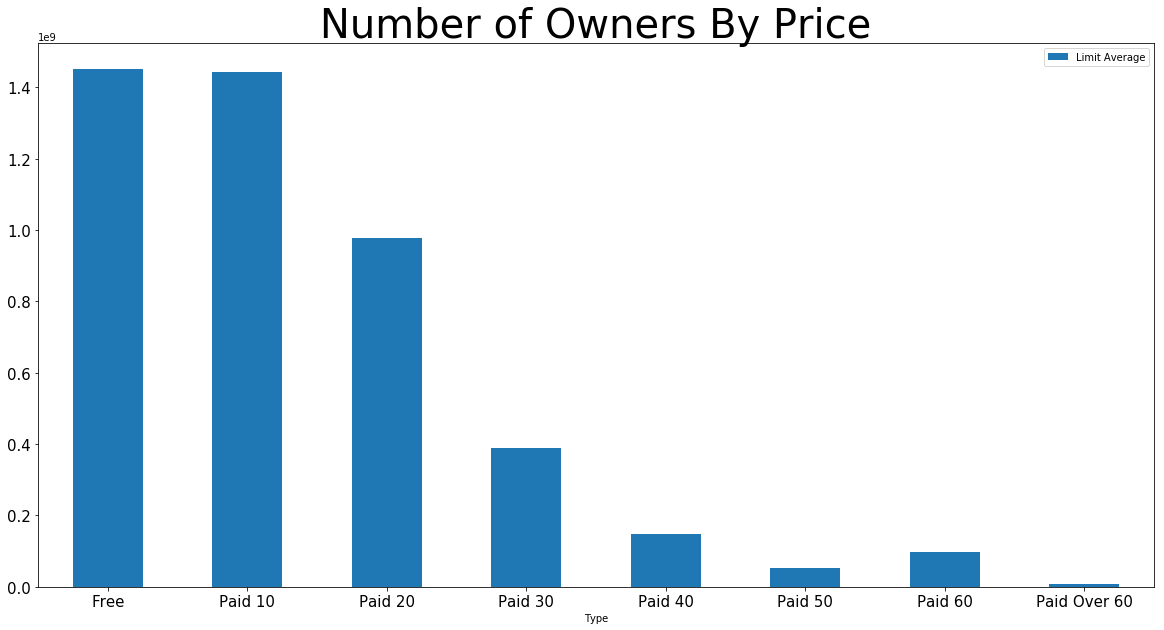

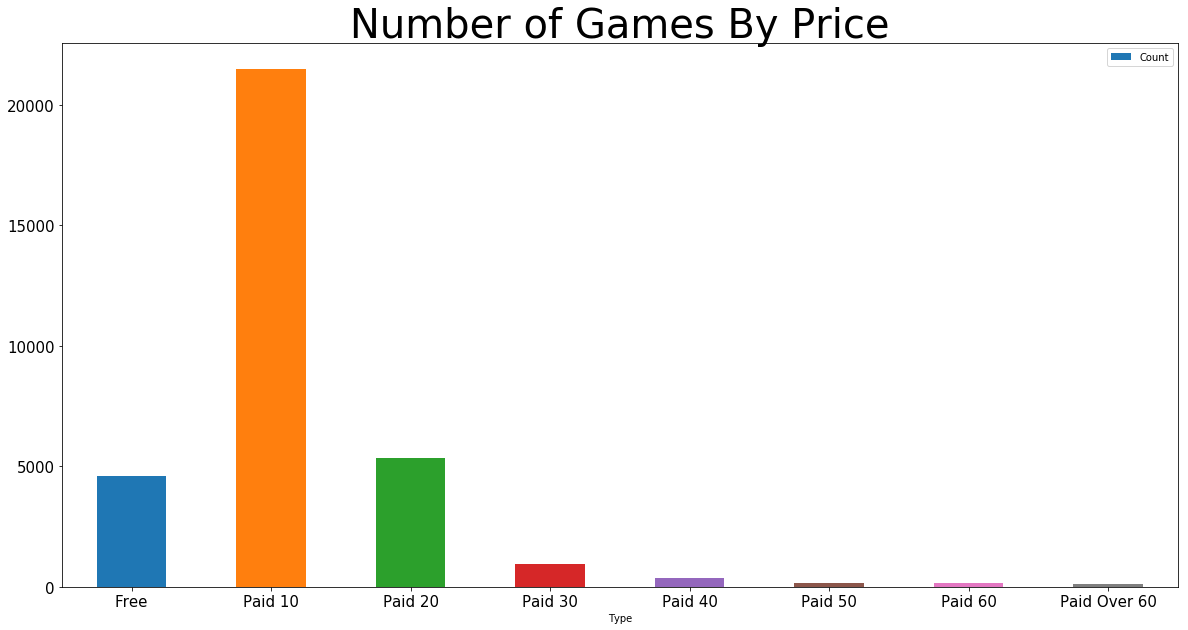

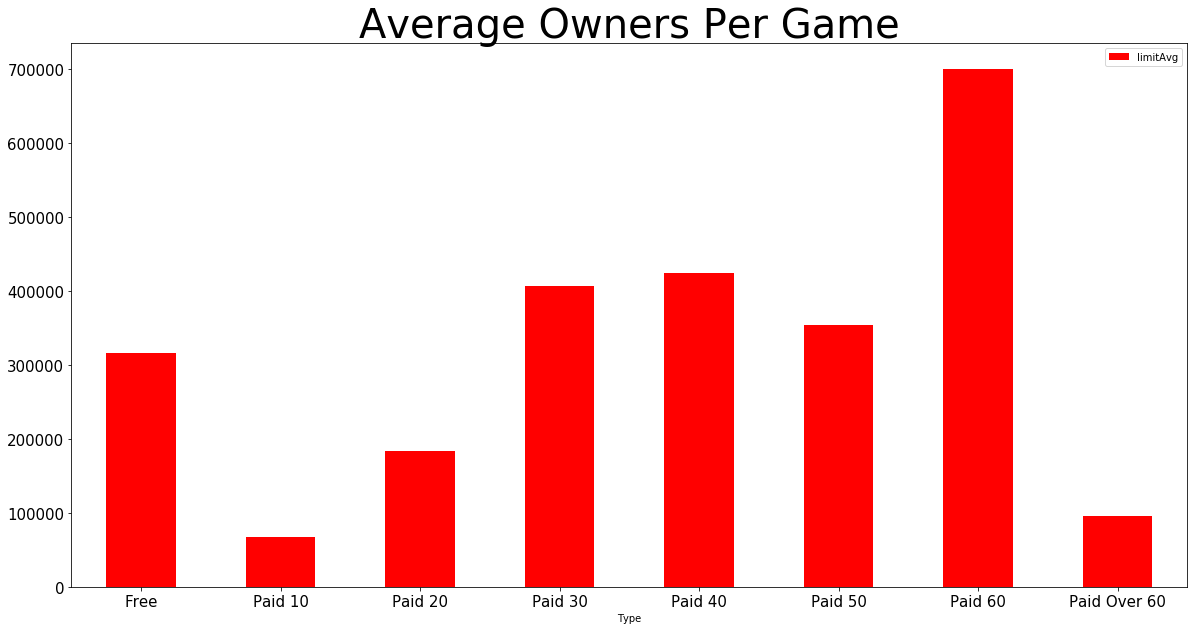

In [23]:
#owners by price point without truncation
plotOwners(priceOfGame, priceNames, title1 = "Number of Owners By Price", title2 = "Number of Games By Price",
           title3 = "Average Owners Per Game")

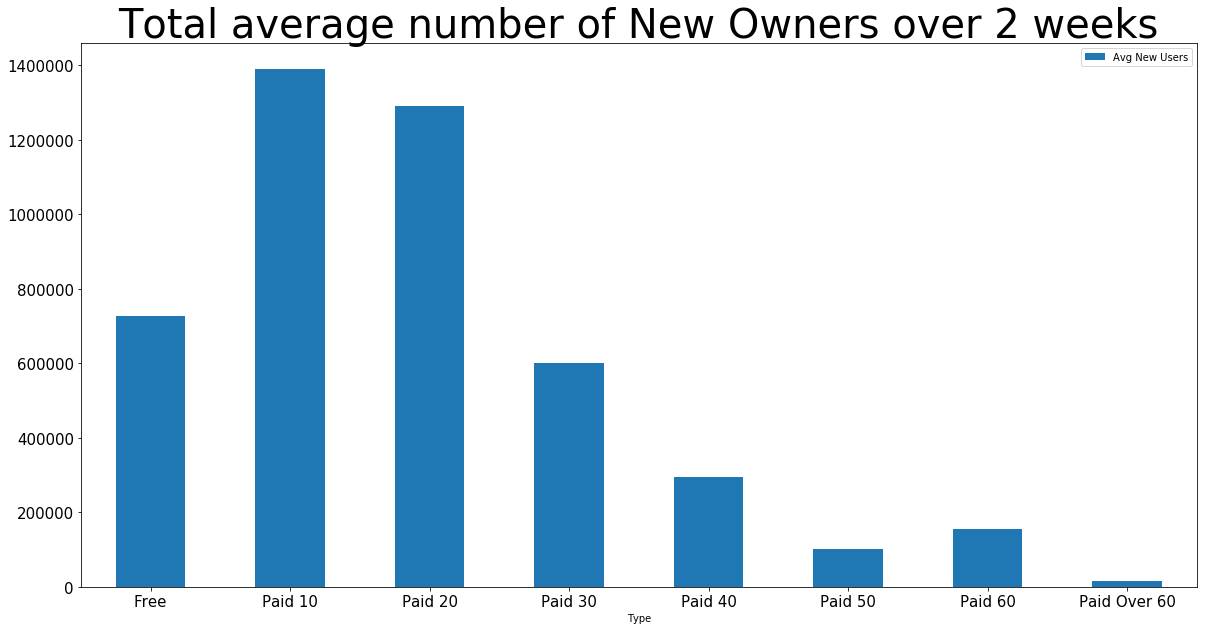

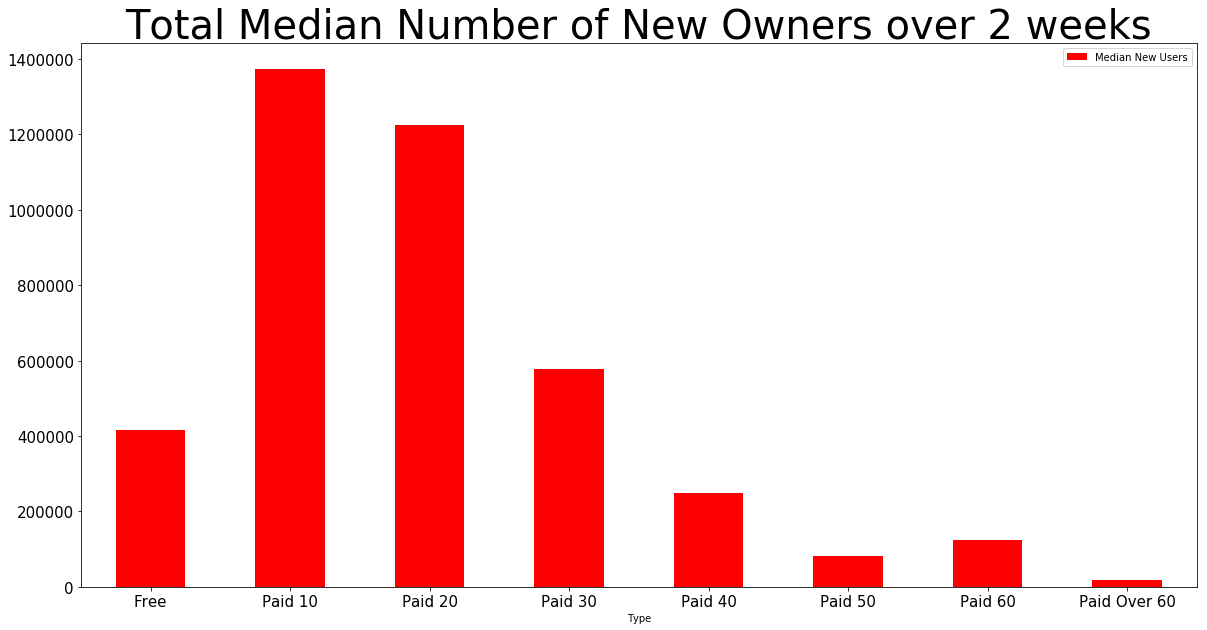

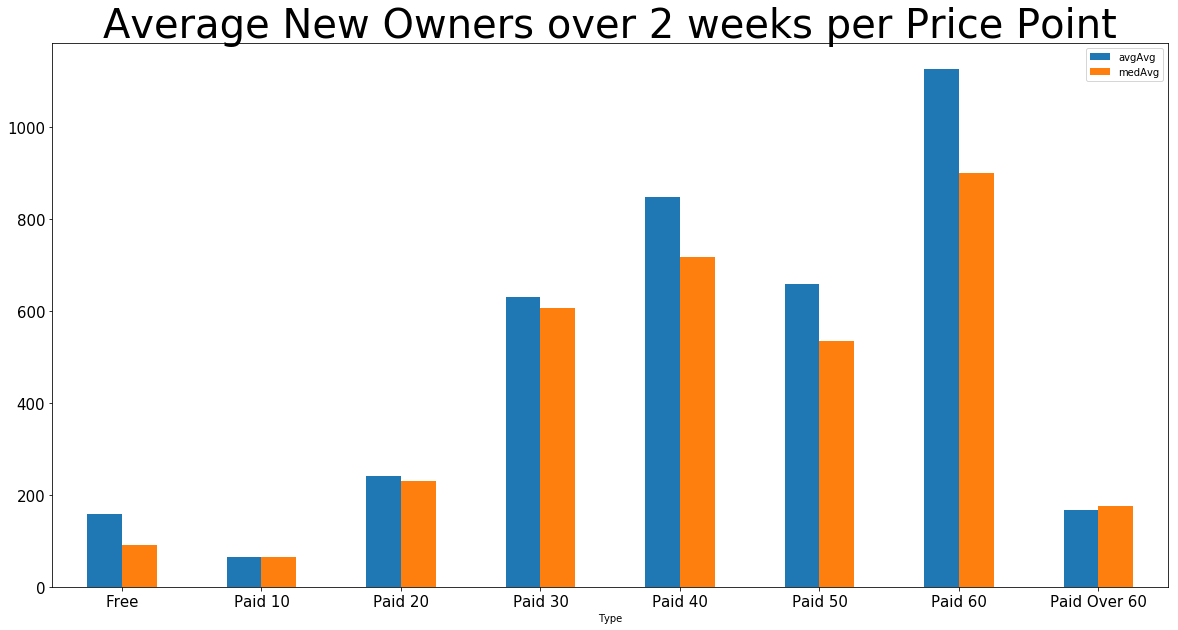

In [24]:
plotNewOwners(priceOfGame, priceNames, title1 = "Total average number of New Owners over 2 weeks", 
              title2 = "Total Median Number of New Owners over 2 weeks",
              title3 = "Average New Owners over 2 weeks per Price Point")

In [29]:
data.head(20)

,Genres,Tags,appid,average_2weeks,average_forever,developer,initialprice,llOwners,median_2weeks,median_forever,name,negative,positive,price,publisher,score_rank,ulOwners,userscore,Like/Dislike Ratio
0,"[Action, Strategy, Free]","[Multiplayer, Co-op, Difficult, Fantasy, Onlin...",570,1644,29989,Valve,0,100000000.0,765,1284,Dota 2,174020,1018172,0,Valve,,200000000.0,0,5.850891
1,"[Action, Adventure, Ex Early Access, MMO]","[Casual, Multiplayer, Open+World, Co-op, Diffi...",578080,731,22291,PUBG Corporation,2999,50000000.0,319,10240,PLAYERUNKNOWN'S BATTLEGROUNDS,584495,678327,2999,PUBG Corporation,,100000000.0,0,1.160535
2,"[Action, Free]","[Multiplayer, Co-op, Shooter, First-Person, Fu...",440,1377,8895,Valve,0,50000000.0,213,452,Team Fortress 2,37107,588020,0,Valve,,100000000.0,0,15.846606
3,"[Action, Free]","[Multiplayer, Co-op, Difficult, Shooter, First...",730,969,25886,"Valve, Hidden Path Entertainment",0,20000000.0,363,7129,Counter-Strike: Global Offensive,470639,3295593,0,Valve,,50000000.0,0,7.002380
4,"[Action, Indie, Adventure, Ex Early Access, Free]","[Singleplayer, Casual, Multiplayer, Atmospheri...",304930,1091,2739,Smartly Dressed Games,0,20000000.0,39,298,Unturned,33383,321907,0,Smartly Dressed Games,,50000000.0,0,9.642842
5,"[Action, Free]","[Singleplayer, Multiplayer, Co-op, Shooter, Sc...",230410,549,6329,Digital Extremes,0,20000000.0,202,367,Warframe,28276,296005,0,Digital Extremes,,50000000.0,0,10.468418
6,"[Action, Adventure]","[Singleplayer, Multiplayer, Great+Soundtrack, ...",271590,608,8587,Rockstar North,2999,20000000.0,272,4645,Grand Theft Auto V,158455,518775,2999,Rockstar Games,,50000000.0,0,3.273958
7,[Action],"[Multiplayer, Open+World, Shooter, First-Perso...",10,287,12988,Valve,999,20000000.0,36,166,Counter-Strike,3754,144330,999,Valve,,50000000.0,0,38.446990
8,"[Action, Indie, Ex Early Access, Free]","[Singleplayer, Casual, Multiplayer, 2D, Co-op,...",291550,336,1682,Blue Mammoth Games,0,20000000.0,140,162,Brawlhalla,18937,105911,0,Ubisoft,,50000000.0,0,5.592808
9,[Action],"[Singleplayer, Multiplayer, Atmospheric, Diffi...",240,97,6682,Valve,999,20000000.0,55,564,Counter-Strike: Source,4020,93460,999,Valve,,50000000.0,0,23.248756


In [30]:
# ordereddata = data.sort_values(by=['llOwners','ulOwners'], ascending=False)
# truncatedData = ordereddata.iloc[20:]
truncatedData = data[data['llOwners'] < 10000000]

In [31]:
free = truncatedData[truncatedData.price == 0]
paid10 = truncatedData[(truncatedData.price < 1001) & (truncatedData.price > 0)] #games between 0.01-10 dollars
paid20 = truncatedData[(truncatedData.price > 1000) & (truncatedData.price < 2001)]
paid30 = truncatedData[(truncatedData.price > 2000) & (truncatedData.price < 3001)]
paid40 = truncatedData[(truncatedData.price > 3000) & (truncatedData.price < 4001)]
paid50 = truncatedData[(truncatedData.price > 4000) & (truncatedData.price < 5001)]
paid60 = truncatedData[(truncatedData.price > 5000) & (truncatedData.price < 6001)]
paidOver60 = truncatedData[truncatedData.price > 6000]

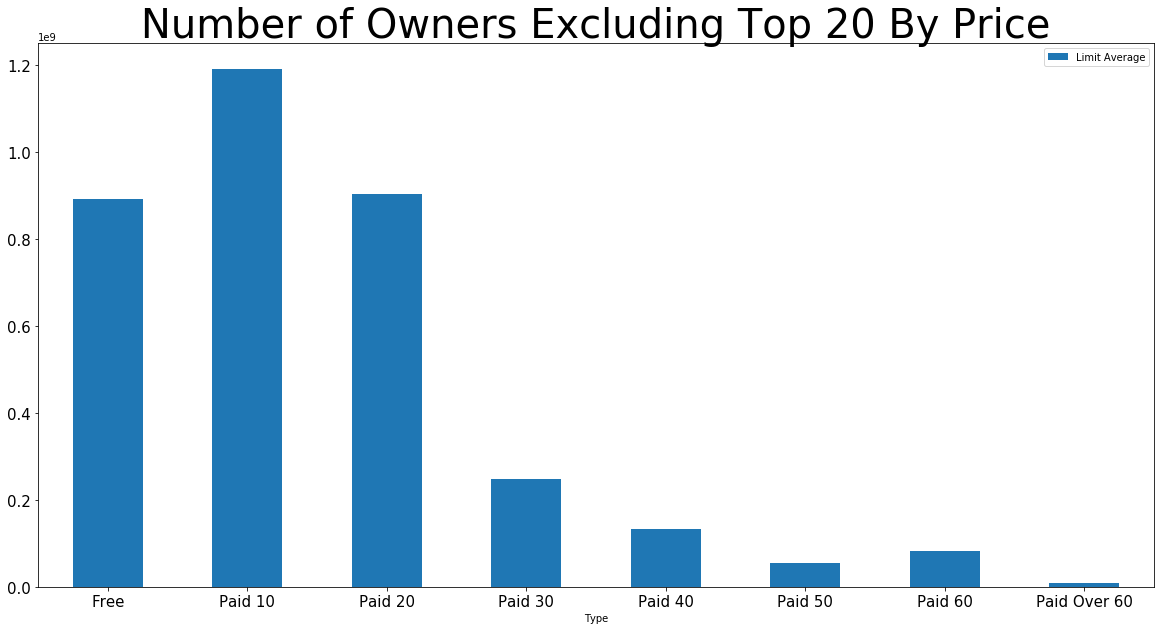

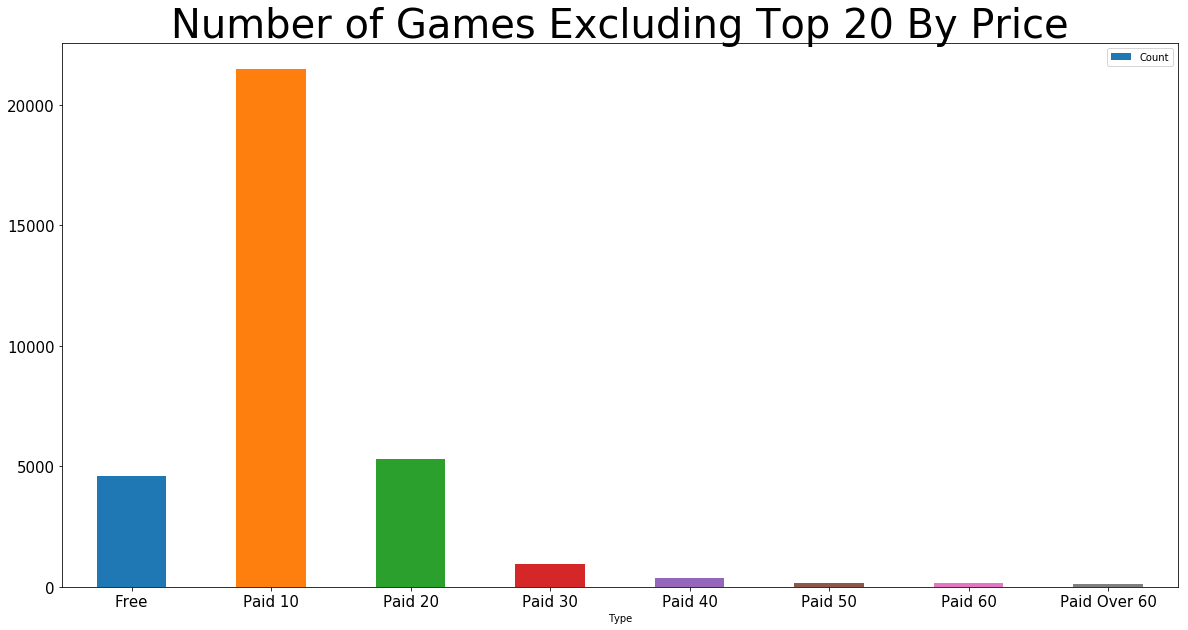

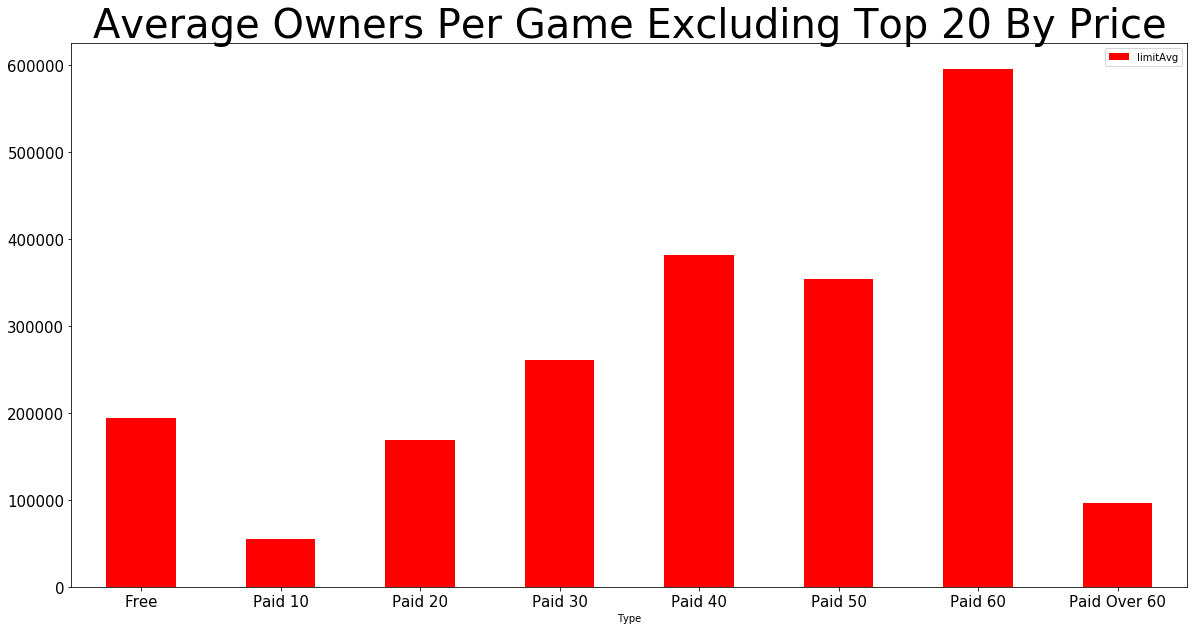

In [32]:
#owners of price points without top 20
priceOfGame = [free, paid10, paid20, paid30, paid40, paid50, paid60, paidOver60]
priceNames = ['Free', 'Paid 10', 'Paid 20', 'Paid 30', 'Paid 40', 'Paid 50', 'Paid 60', 'Paid Over 60']
plotOwners(priceOfGame, priceNames, title1 = "Number of Owners Excluding Big Games By Price", title2 = 
           "Number of Games Excluding Big Games By Price", 
           title3 = "Average Owners Per Game Excluding Big Games By Price")